<a href="https://colab.research.google.com/github/0ginny/TIL/blob/main/240605_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%88%98%EC%9A%94%EC%98%88%EC%B8%A1_%ED%9B%88%EB%A0%A8%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주제 : 머신러닝 수요 예측

## 0. 라이브러리 불러오기

In [1]:
### 데이터 다루는 라이브러리
import pandas as pd
import numpy as np
### 머신러닝 라이브러리
from sklearn import tree
### 시각화 라이브러리
import matplotlib.pyplot as plt

In [11]:
from sklearn.preprocessing import LabelEncoder

In [52]:
from sklearn.model_selection import train_test_split

In [61]:
from sklearn.tree import plot_tree

In [79]:
import pickle

### 데이터 불러오

In [3]:
# https://github.com/hyokwan -> python-lect -> dataset
data_url = "https://raw.githubusercontent.com/hyokwan/python-lecture/master/dataset/feature_regression_example.csv"
featuresData = pd.read_csv(data_url)

In [5]:
featuresData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225,Y,1,Y,0.209442
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968,N,4,Y,0.209442
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201503,2015,3,1209,N,4,Y,0.208155
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201504,2015,4,1810,Y,2,Y,0.208155
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201505,2015,5,1773,N,4,Y,0.208155


## 1. 데이터 타입 통합 및 특성 숫자 칼럼 추가

In [6]:
featuresData.dtypes

REGIONID         object
PRODUCTGROUP     object
PRODUCT          object
ITEM             object
YEARWEEK          int64
YEAR              int64
WEEK              int64
QTY               int64
HOLIDAY          object
HCLUS             int64
PROMOTION        object
PRO_PERCENT     float64
dtype: object

In [ ]:
# table 정의서에 맞춰서
featuresData['YEARWEEK'] = featuresData.YEARWEEK.astype(int)
featuresData['YEAR'] = featuresData.YEAR.astype(int)
featuresData['WEEK'] = featuresData.WEEK.astype(int)
featuresData['QTY'] = featuresData.QTY.astype(int)
featuresData['HCLUS'] = featuresData.HCLUS.astype(int)
featuresData['PRO_PERCENT'] = featuresData.PRO_PERCENT.astype(float)

In [ ]:
featuresData.columns = featuresData.columns.str.upper()

#### HOLYDAY PROMOTION 숫자화


In [17]:
# 라벨링할 데이터의 종류값들을 확인
# 단순 abc 순서대로 라벨을 만드는 것이 아니라, 값마다 중요도가 다른 라벨이 있을 수 있어.
# ex ) vip, diamond, common
featuresData.HOLIDAY.drop_duplicates(),featuresData.PROMOTION.drop_duplicates()

(0    Y
 1    N
 Name: HOLIDAY, dtype: object,
 0    Y
 9    N
 Name: PROMOTION, dtype: object)

In [13]:
ynEncoder = LabelEncoder()

In [18]:
featuresData["LE_HOLIDAY"] = ynEncoder.fit_transform(featuresData.HOLIDAY)
featuresData["LE_PROMOTION"] =ynEncoder.transform(featuresData.PROMOTION)

In [19]:
ynEncoder.classes_

array(['N', 'Y'], dtype=object)

In [20]:
featuresData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,LE_HOLIDAY,LE_PROMOTION
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225,Y,1,Y,0.209442,1,1
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968,N,4,Y,0.209442,0,1
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201503,2015,3,1209,N,4,Y,0.208155,0,1
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201504,2015,4,1810,Y,2,Y,0.208155,1,1
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201505,2015,5,1773,N,4,Y,0.208155,0,1


## 2. 특성 선정 및 데이터 분리

In [25]:
# 모든 데이터만 쓰는 것이 아니라, 목표 칼럼과 상관관계가 있는 데이터만 사용
corrStd = 0.5 # 적어도 0.5보다는 큰 상관관계만 사용하겠다.

In [35]:
# 확인할 목표 칼럼
label = ["QTY"]

In [31]:
corrDf = featuresData.corr(numeric_only=True)

In [49]:
corrDf.QTY

YEARWEEK        0.112267
YEAR            0.028931
WEEK            0.289766
QTY             1.000000
HCLUS          -0.537230
PRO_PERCENT     0.700195
LE_HOLIDAY      0.505932
LE_PROMOTION    0.612451
Name: QTY, dtype: float64

In [50]:
features = list(corrDf[(abs(corrDf[label[0]]) >= corrStd) &
                    (corrDf[label[0]] != 1)].index)

In [51]:
features

['HCLUS', 'PRO_PERCENT', 'LE_HOLIDAY', 'LE_PROMOTION']

In [59]:
# 보통 시계열 데이터는 년도 같은 기준을 잡고 과거와 최근과 가까운 과거로 나눠서 train과 test를 나눠
featuresData.YEAR.drop_duplicates()

0     2015
53    2016
Name: YEAR, dtype: int64

In [ ]:
randomValue = 30

In [54]:
trainData,testData = train_test_split(featuresData, test_size = 0.2, random_state = randomValue)

In [55]:
trainData.shape, testData.shape, featuresData.shape

((84, 14), (21, 14), (105, 14))

In [56]:
trainDataFeatures = trainData.loc[:, features]
trainDataLabel = trainData.loc[:,label]
testDataFeatures = testData.loc[:, features]
testDataLabel = testData.loc[:,label]

In [57]:
print(trainDataFeatures.shape)
print(trainDataLabel.shape)
print(testDataFeatures.shape)
print(testDataLabel.shape)

(84, 4)
(84, 1)
(21, 4)
(21, 1)


## 3.데이터 모델 생성 및 훈련

In [60]:
# decision tree 사용
dtModel = tree.DecisionTreeRegressor(random_state=randomValue)

In [62]:
fittedDtModel = dtModel.fit(trainDataFeatures,trainDataLabel)

[Text(0.39903846153846156, 0.9285714285714286, 'PRO_PERCENT <= 0.259\nsquared_error = 678824.471\nsamples = 84\nvalue = 1253.202'),
 Text(0.17307692307692307, 0.7857142857142857, 'PRO_PERCENT <= 0.104\nsquared_error = 275912.341\nsamples = 51\nvalue = 838.824'),
 Text(0.07692307692307693, 0.6428571428571429, 'HCLUS <= 3.0\nsquared_error = 65686.055\nsamples = 17\nvalue = 341.941'),
 Text(0.038461538461538464, 0.5, 'squared_error = 0.0\nsamples = 1\nvalue = 15.0'),
 Text(0.11538461538461539, 0.5, 'squared_error = 62693.234\nsamples = 16\nvalue = 362.375'),
 Text(0.2692307692307692, 0.6428571428571429, 'HCLUS <= 3.0\nsquared_error = 195856.43\nsamples = 34\nvalue = 1087.265'),
 Text(0.19230769230769232, 0.5, 'PRO_PERCENT <= 0.224\nsquared_error = 200358.691\nsamples = 9\nvalue = 1340.556'),
 Text(0.15384615384615385, 0.35714285714285715, 'PRO_PERCENT <= 0.209\nsquared_error = 157896.0\nsamples = 4\nvalue = 1126.0'),
 Text(0.11538461538461539, 0.21428571428571427, 'HCLUS <= 1.5\nsquared_e

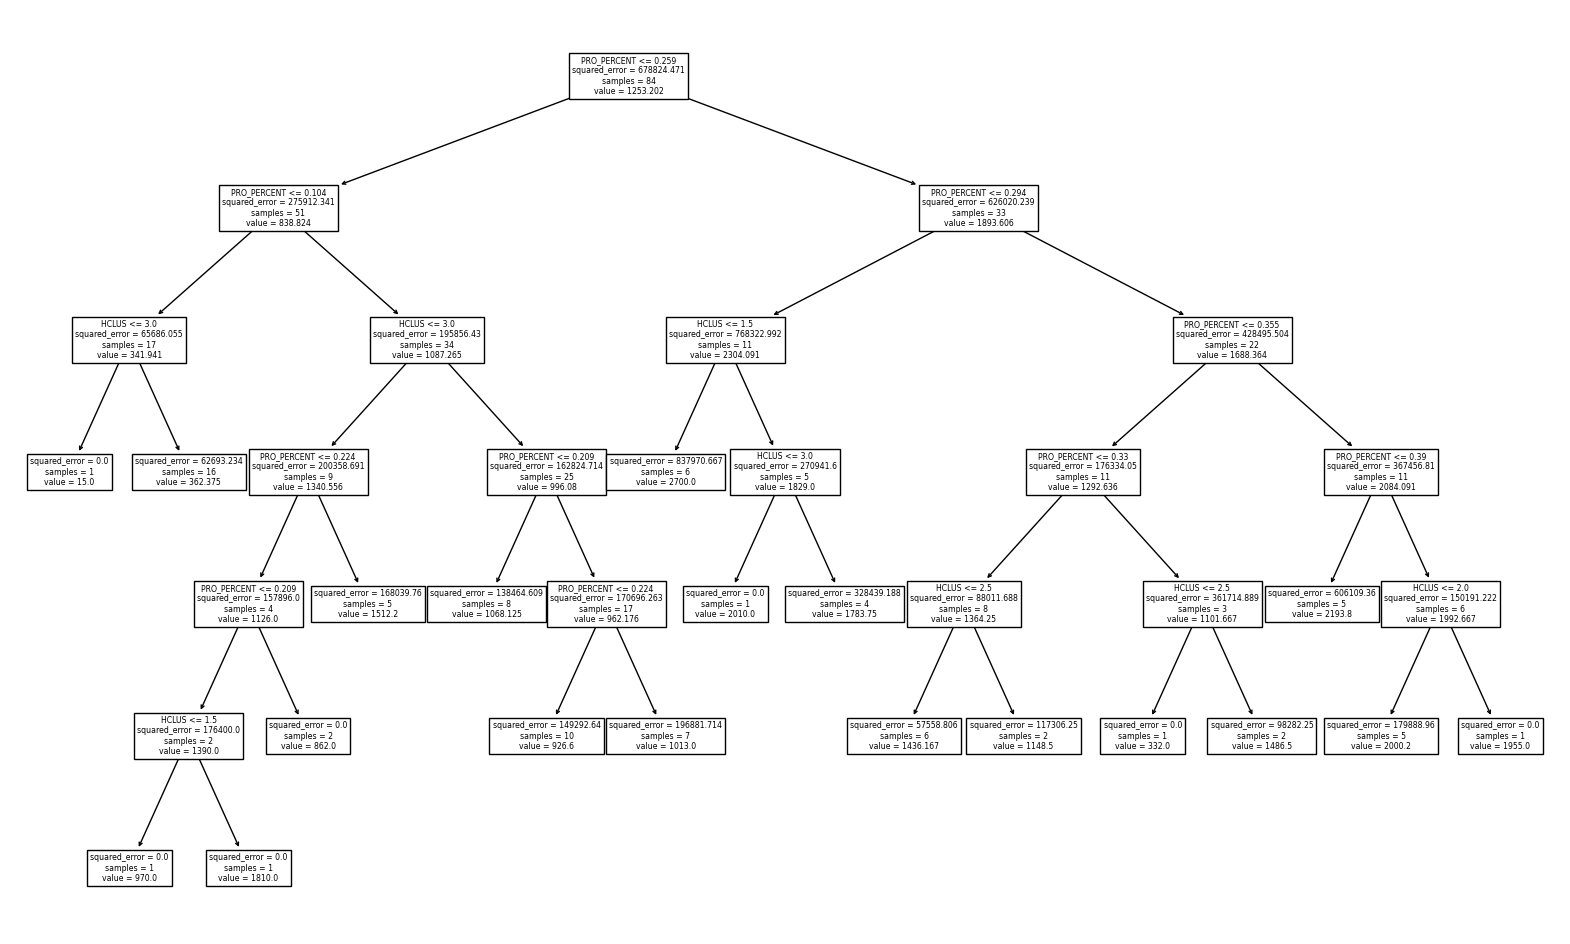

In [77]:
# 왜 그렇게 나왔는지 해석을 할 줄 알아야해.
plt.figure(figsize=(20,12))
plot_tree(fittedDtModel, feature_names=features)

위에서부터 의사결정 트리에 대해 설명할 수 있도록.

## 4. 예측

In [67]:
features

['HCLUS', 'PRO_PERCENT', 'LE_HOLIDAY', 'LE_PROMOTION']

In [75]:
inHclus = 1
inPropercent = 0.4
inHoliday = 0 #'Y'
inPromotion = 0 #'Y'
inDf = pd.DataFrame([[inHclus,inPropercent,inHoliday,inPromotion]])
fittedDtModel.predict(inDf)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([2000.2])

질문

1. holiday와 promotion이 영향을 주지 않는 건, 그냥 상관관계가 적어서 그런 것인가?
2. 파이널 셈플을 확인해보면 10개인 것도 있는데, 더 세부적으로 나눌 수는 없나?



## 5. 훈련모델 저장

재료 : 모델(fittedDfModel), feature, label, encoder

In [78]:
modelDict = {
    'features' : features,
    'label' : label,
    'preprocessing' : [None, None, ynEncoder, ynEncoder],
    'model' : fittedDtModel
}

In [80]:
filePath = '240605_first_QTY_regretion.dump'
with open(filePath,'wb') as fw:
    pickle.dump(modelDict,fw)